## Predicting Fraudulent Detection by Talib Hussain Ansari

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Inspiration
Identify fraudulent credit card transactions.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [2]:
data = pd.read_csv('Fraud.csv',sep=',')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
from sklearn.preprocessing import LabelEncoder;
lb=LabelEncoder()
data['type']=lb.fit_transform(data['type'])
data=data.drop(['nameOrig','nameDest'],axis=1)
data.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int32(1), int64(3)
memory usage: 412.6 MB


## Exploratory Data Analysis

In [5]:
data.isnull().values.any()

False

C:\Users\Dell\AppData\Local\Temp\ipykernel_10520\2707685817.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['isFraud'], sort = True)


Text(0, 0.5, 'Frequency')

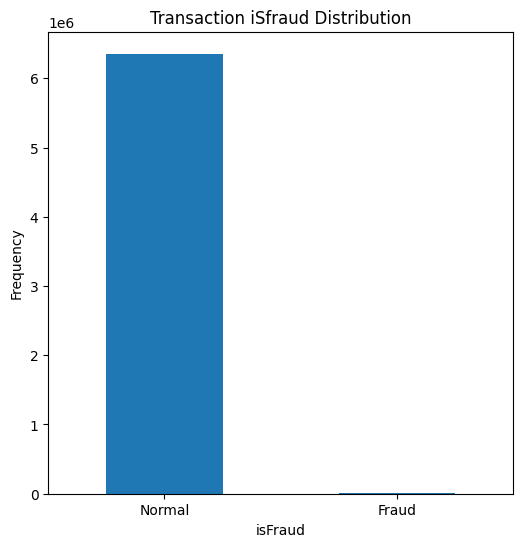

In [6]:
plt.figure(figsize=(6,6))
count_classes = pd.value_counts(data['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction iSfraud Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("isFraud")

plt.ylabel("Frequency")

In [7]:
## Get the Fraud and the normal dataset 

fraud = data[data['isFraud']==1]

normal = data[data['isFraud']==0]

In [8]:
print(fraud.shape,normal.shape)

(8213, 9) (6354407, 9)


In [9]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [10]:
normal.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

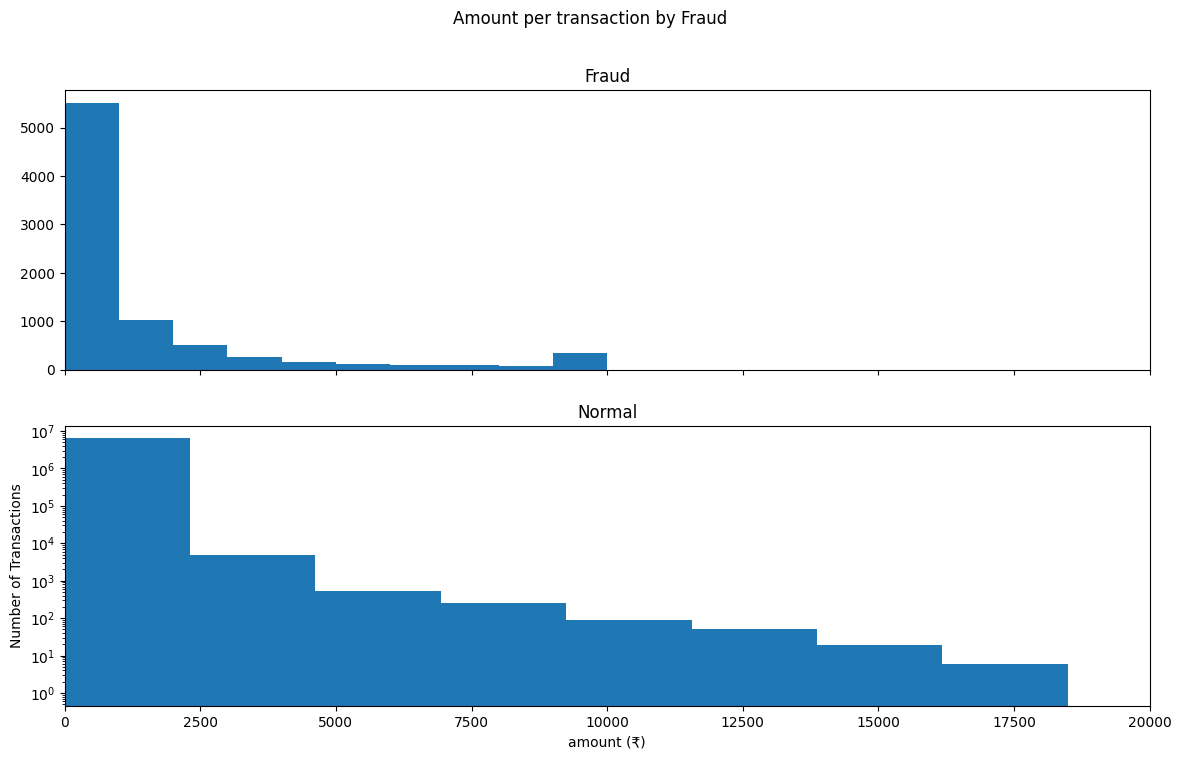

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by Fraud')
bins = 50
ax1.hist(fraud.amount/1000)
ax1.set_title('Fraud')
ax2.hist(normal.amount/4000)
ax2.set_title('Normal')
plt.xlabel('amount (₹)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

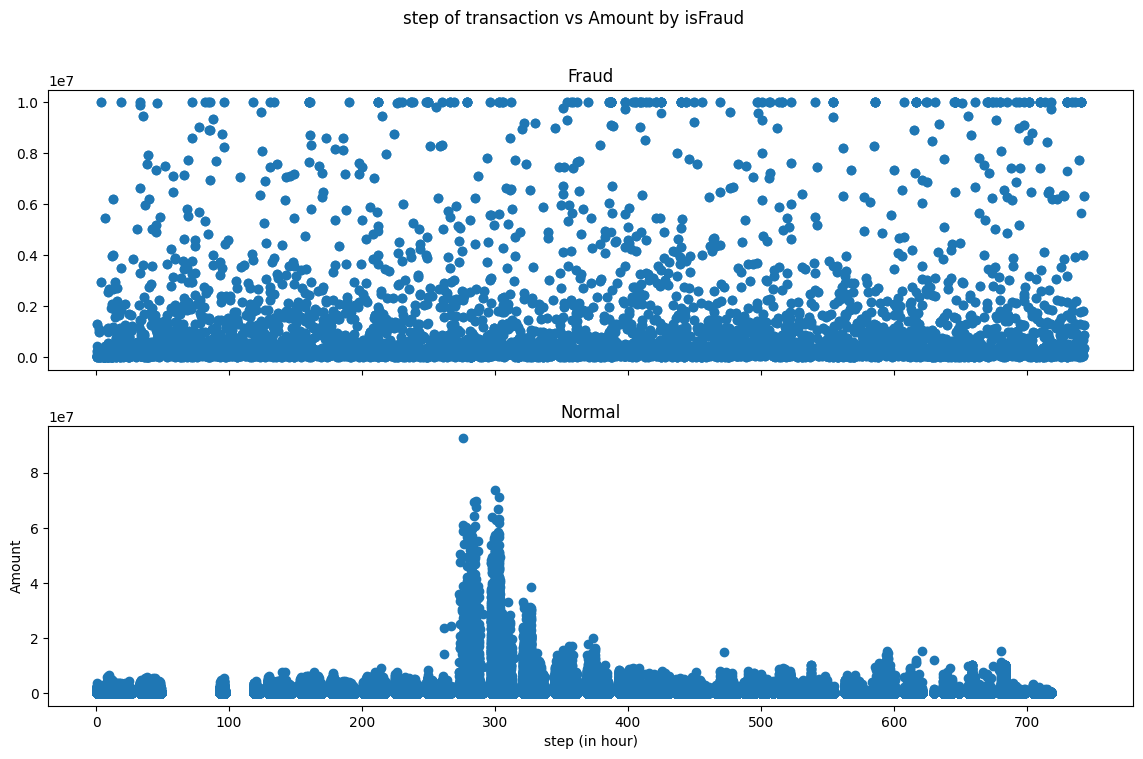

In [12]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('step of transaction vs Amount by isFraud')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(normal.step, normal.amount)
ax2.set_title('Normal')
plt.xlabel('step (in hour)')
plt.ylabel('Amount')
plt.show()

In [13]:
## Take some sample of the data


data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(636262, 9)

In [14]:
data.shape

(6362620, 9)

In [15]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['isFraud']==1]

Valid = data1[data1['isFraud']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [16]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0012888646188564514
Fraud Cases : 819
Valid Cases : 635443


<Figure size 1000x1200 with 0 Axes>

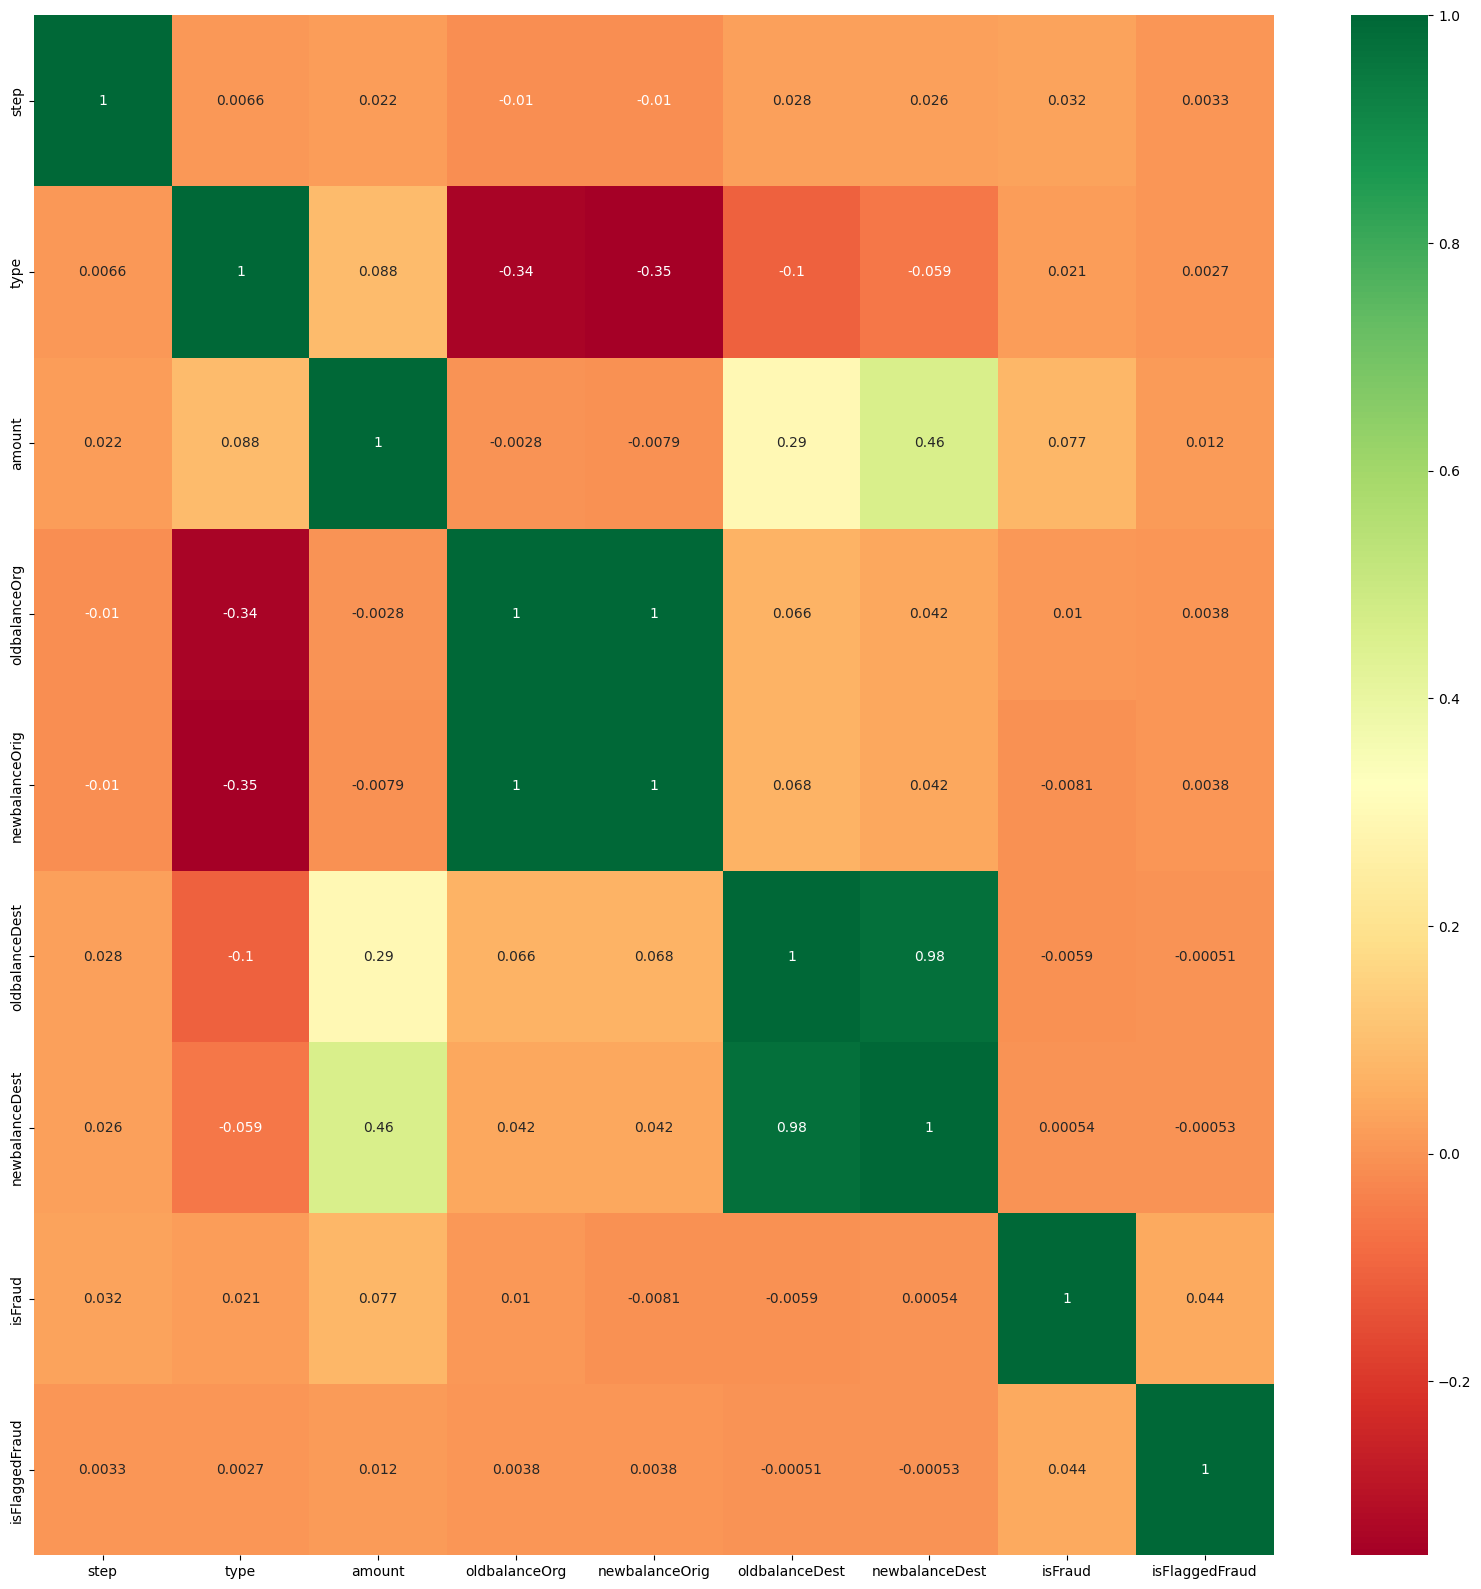

In [17]:
## Correlation
plt.figure(figsize=(10,12))
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [20]:
state = np.random.RandomState(42)
X=data[['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]
Y=data['isFraud']
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(6362620, 8)
(6362620,)


In [ ]:
X.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [44]:
from sklearn.model_selection import train_test_split
x=X.sample(frac = 0.01,random_state=1)
y=Y.sample(frac = 0.01,random_state=1)
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2)

In [45]:
x_test.head(5)
print(x_train.size)
print(x_test.size)

407200
101808


## Model Prediction





Now it is time to start building the model .The types of algorithms I am going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [46]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(x_test), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [47]:
type(classifiers)

dict

In [48]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        clf.fit(x_train)
        y_pred = clf.fit_predict(x_test)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(x_train)
        y_pred = clf.predict(x_test)
    else:    
        clf.fit(x_train)
        scores_prediction = clf.decision_function(x_test)
        y_pred = clf.predict(x_test)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_test).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_test,y_pred))
    print("Classification Report :")
    print(classification_report(y_test,y_pred))



Isolation Forest: 33
Accuracy Score :
0.9974068835454974
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12714
           1       0.00      0.00      0.00        12

    accuracy                           1.00     12726
   macro avg       0.50      0.50      0.50     12726
weighted avg       1.00      1.00      1.00     12726

Local Outlier Factor: 27
Accuracy Score :
0.9978783592644979
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12714
           1       0.06      0.08      0.07        12

    accuracy                           1.00     12726
   macro avg       0.53      0.54      0.53     12726
weighted avg       1.00      1.00      1.00     12726

Support Vector Machine: 12714
Accuracy Score :
0.000942951438000943
Classification Report :
              precision    recall  f1-score   support

           0       0.00      0.00

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Observations :
- Isolation Forest detected 33 errors versus Local Outlier Factor detecting 27 errors vs.
- Isolation Forest has a 0.9978783592644979 accurate and LOF of 0.9978783592644979 and SVM of 70.09
- When comparing error precision & recall for 3 models , the LOF performed better than the Isolation Forestas.
- So overall Isolation Forest and LOF Method performed much better in determining the fraud cases.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases